In [1]:
import pbjam as pb
from pbjam.jar import session
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk 
import sys

In [2]:
kic = '4448777'
numax = [220.0, 3.0]
dnu = [16.97, 0.01]
teff = [4750, 100]
bp_rp = [1.34, 0.01]

In [3]:
# Initialize a jam session with a single star:
jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], bp_rp = [bp_rp], nthreads=1)

In [4]:
# Result is always a list of star class instances
# Taking the first one as an example
star = jam_sess.stars[0]

In [5]:
star.asymptotic_modeid(norders = 7)

Burningham
Sampling


In [6]:
print(star.asy_modeID)

    ell       nu_mu    nu_std
0     2  157.472890  0.041523
1     0  159.679574  0.039019
2     2  174.074538  0.024600
3     0  176.280566  0.021465
4     2  190.800610  0.015915
5     0  193.006546  0.012293
6     2  207.651426  0.013260
7     0  209.858082  0.010044
8     2  224.627079  0.012270
9     0  226.832758  0.009370
10    2  241.727321  0.015022
11    0  243.933231  0.012652
12    2  258.952052  0.026829
13    0  261.158510  0.025226


In [7]:
print(star.asy_bestfit)

{'numax': array([221.26415867, 222.81524462, 224.11176124]), 'dnu': array([16.99756467, 17.00945422, 17.01693557]), 'eps': array([1.32976662, 1.33552686, 1.34472827]), 'alpha': array([0.00693954, 0.00733392, 0.00773657]), 'd02': array([2.19179173, 2.20626068, 2.22024473]), 'env_height': array([4.29586799, 4.30578406, 4.31045657]), 'env_width': array([57.09900396, 57.38428435, 58.08410227]), 'mode_width': array([-0.32484967, -0.31305299, -0.30083095]), 'teff': array([4808.25425823, 4875.98873507, 4951.02903046]), 'bp_rp': array([1.3278271 , 1.33773532, 1.34843846])}


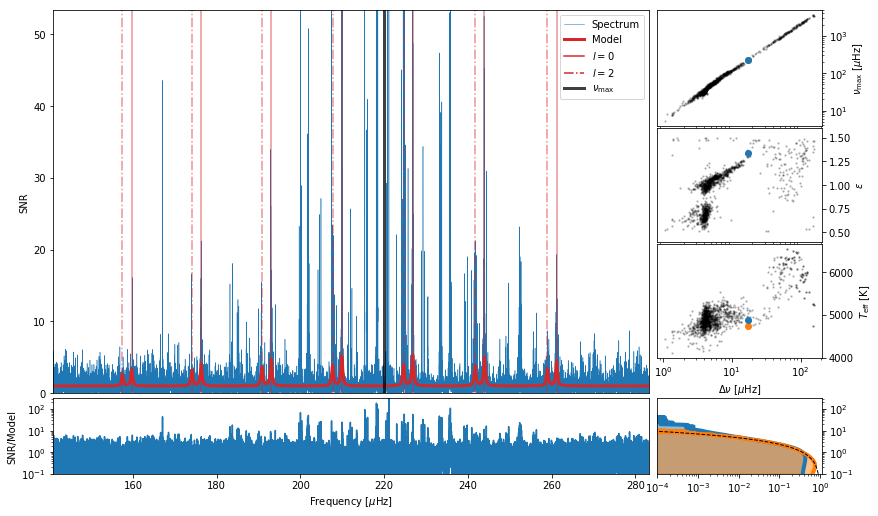

In [8]:
fig = star.plot_asyfit()